# STEP 1 

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read Data

In [2]:
# Read the data using pandas into a pandas dataframe
bank_data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

## Check head, datatypes, summary, shape, nulls, incorrect imputations

In [3]:
bank_data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


<b> INSIGHTS :  We can see that ID is a primary ke which can be dropped from Model building
    Zip Code can also be dropped as it is a categorical column with high cardinality and I dont think it is suitable for one hot encoding

In [4]:
bank_data.shape

(5000, 14)

In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


<b>INSIGHTS: From the info we can see the none of the entries are null and all columns are either integer or float values

In [6]:
bank_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


<b> INSIGHTS 
<br>
    1 . From the describe funcion we can see that min value of Experience is Negative which shows there is some incorrect or potential missing values

### IMPUTE EXPERIENCE WHERE LESS THAN 0

In [7]:
impute_age = bank_data[bank_data['Experience'] >= 0]
impute_age = impute_age.groupby('Age', as_index = False).agg({
    'Experience' : 'mean'
})

impute_dict = {}
for i,j in impute_age.iterrows():
    age = int(j['Age'])
    exp = int(round(j['Experience']))
    impute_dict[age] = exp
    
impute_dict[23] = 0


index_to_impute =  list(bank_data[bank_data['Experience'] < 0].sort_values('Age').index)

for index in index_to_impute:
    age = bank_data.loc[index, 'Age']
    exp = impute_dict[age]
    bank_data.loc[index, 'Experience'] = exp

# STEP 2

## Number of unique in each column?

In [8]:
for i in bank_data.columns:
    print(f'{i} : {bank_data[i].nunique()}')

ID : 5000
Age : 45
Experience : 44
Income : 162
ZIP Code : 467
Family : 4
CCAvg : 108
Education : 3
Mortgage : 347
Personal Loan : 2
Securities Account : 2
CD Account : 2
Online : 2
CreditCard : 2


## Number of people with zero mortgage?

In [9]:
mortgage0 = bank_data[bank_data['Mortgage'] == 0].shape[0]
print(f'Number of people with Zero Mortgage is {mortgage0}')

Number of people with Zero Mortgage is 3462


## Number of people with zero credit card spending per month?

In [10]:
creditspend0 = bank_data[bank_data['CCAvg'] == 0].shape[0]
print(f'Number of people with Zero Credit Card Spending  is {creditspend0}')

Number of people with Zero Credit Card Spending  is 106


## Value counts of all categorical columns.

#### Education, Personal Loan, Securities Account, CD Account, Online, CreditCard can be considered as Categorical columns. <br>Zip Code is also a Categorical Column with high cardinality

In [11]:
for i in ['Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']:
    print(bank_data[i].value_counts(), '\n\n')

1    2096
3    1501
2    1403
Name: Education, dtype: int64 


0    4520
1     480
Name: Personal Loan, dtype: int64 


0    4478
1     522
Name: Securities Account, dtype: int64 


0    4698
1     302
Name: CD Account, dtype: int64 


1    2984
0    2016
Name: Online, dtype: int64 


0    3530
1    1470
Name: CreditCard, dtype: int64 




### Univariate and Bivariate

### PAIR PLOT FOR BIVARIATE AND UNIVARIATE DISTRIBUTION

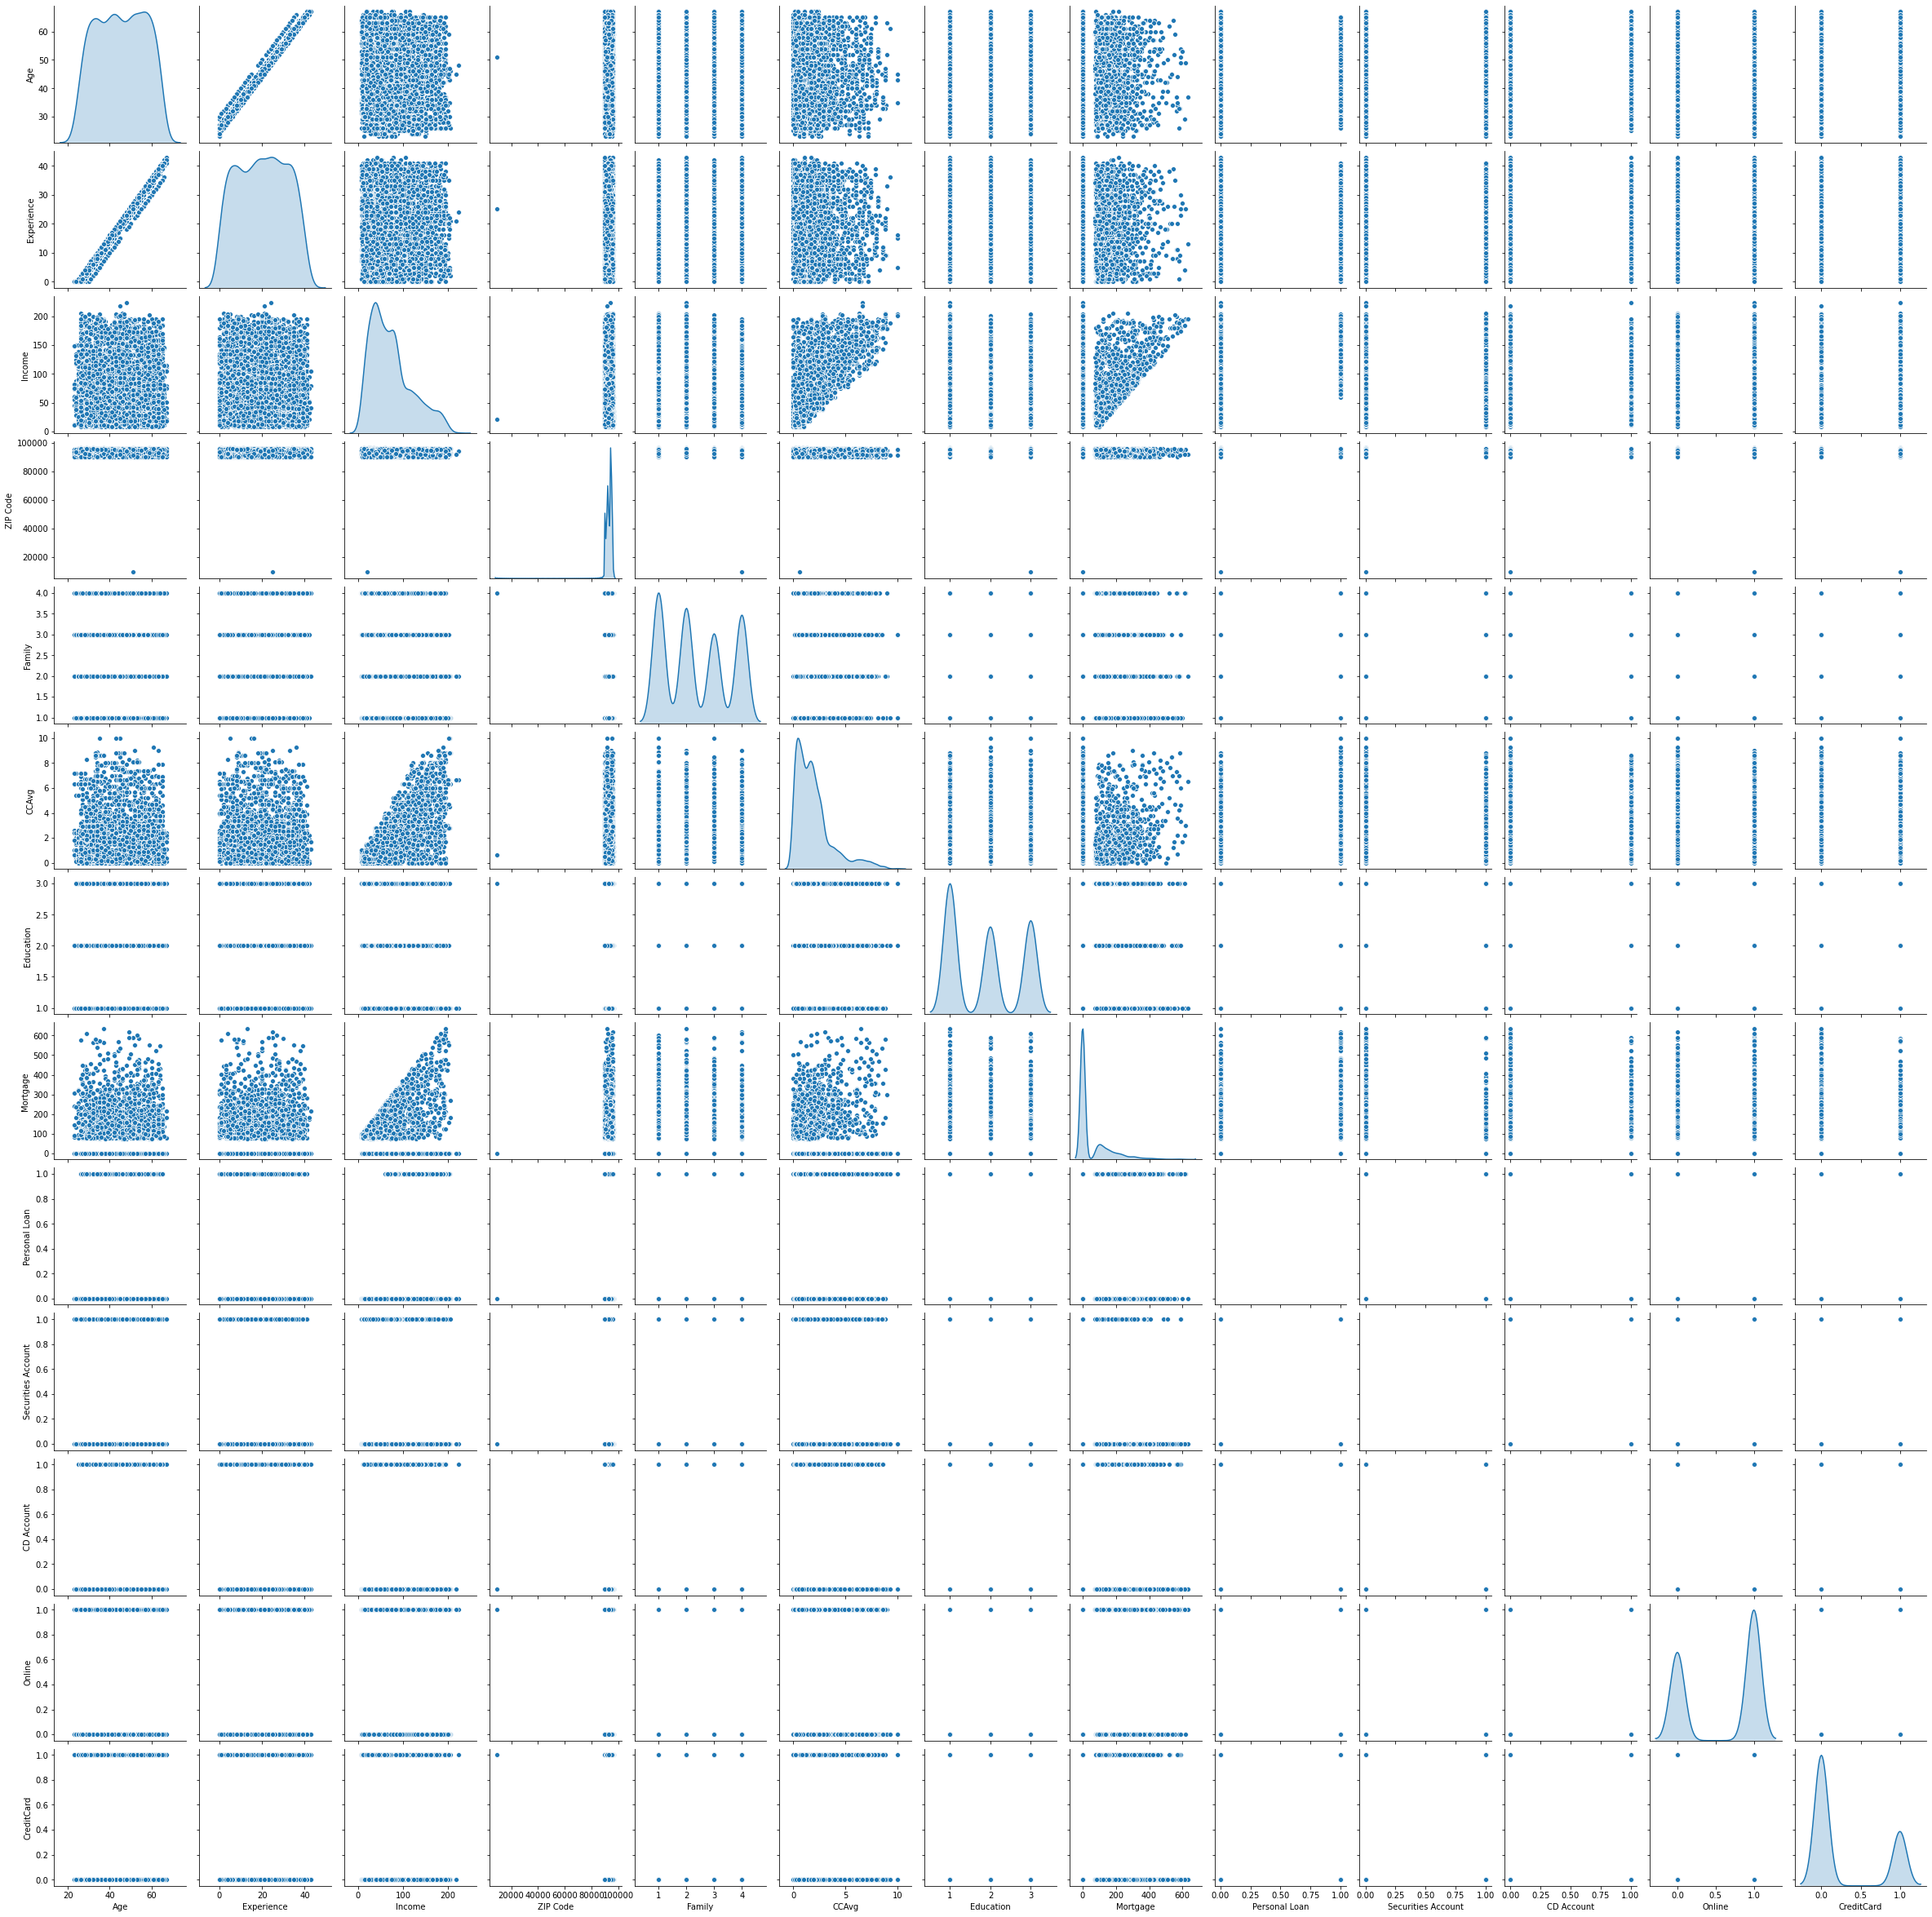

In [12]:
sns.pairplot(bank_data.drop(['ID'], axis = 1), diag_kind='kde')

### CORR MATRIX HEAT MAP 

In [13]:
bank_data.corr()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,1.000000,-0.008473,-0.008152,-0.017695,0.013432,-0.016797,-0.024675,0.021463,-0.013920,-0.024801,-0.016972,-0.006909,-0.002528,0.017028
Age,-0.008473,1.000000,0.994214,-0.055269,-0.029216,-0.046418,-0.052012,0.041334,-0.012539,-0.007726,-0.000436,0.008043,0.013702,0.007681
Experience,-0.008152,0.994214,1.000000,-0.046880,-0.028578,-0.052119,-0.050030,0.014071,-0.010950,-0.008060,-0.001258,0.009905,0.013765,0.009073
Income,-0.017695,-0.055269,-0.046880,1.000000,-0.016410,-0.157501,0.645984,-0.187524,0.206806,0.502462,-0.002616,0.169738,0.014206,-0.002385
ZIP Code,0.013432,-0.029216,-0.028578,-0.016410,1.000000,0.011778,-0.004061,-0.017377,0.007383,0.000107,0.004704,0.019972,0.016990,0.007691
Family,-0.016797,-0.046418,-0.052119,-0.157501,0.011778,1.000000,-0.109275,0.064929,-0.020445,0.061367,0.019994,0.014110,0.010354,0.011588
CCAvg,-0.024675,-0.052012,-0.050030,0.645984,-0.004061,-0.109275,1.000000,-0.136124,0.109905,0.366889,0.015086,0.136534,-0.003611,-0.006689
Education,0.021463,0.041334,0.014071,-0.187524,-0.017377,0.064929,-0.136124,1.000000,-0.033327,0.136722,-0.010812,0.013934,-0.015004,-0.011014
Mortgage,-0.013920,-0.012539,-0.010950,0.206806,0.007383,-0.020445,0.109905,-0.033327,1.000000,0.142095,-0.005411,0.089311,-0.005995,-0.007231
Personal Loan,-0.024801,-0.007726,-0.008060,0.502462,0.000107,0.061367,0.366889,0.136722,0.142095,1.000000,0.021954,0.316355,0.006278,0.002802


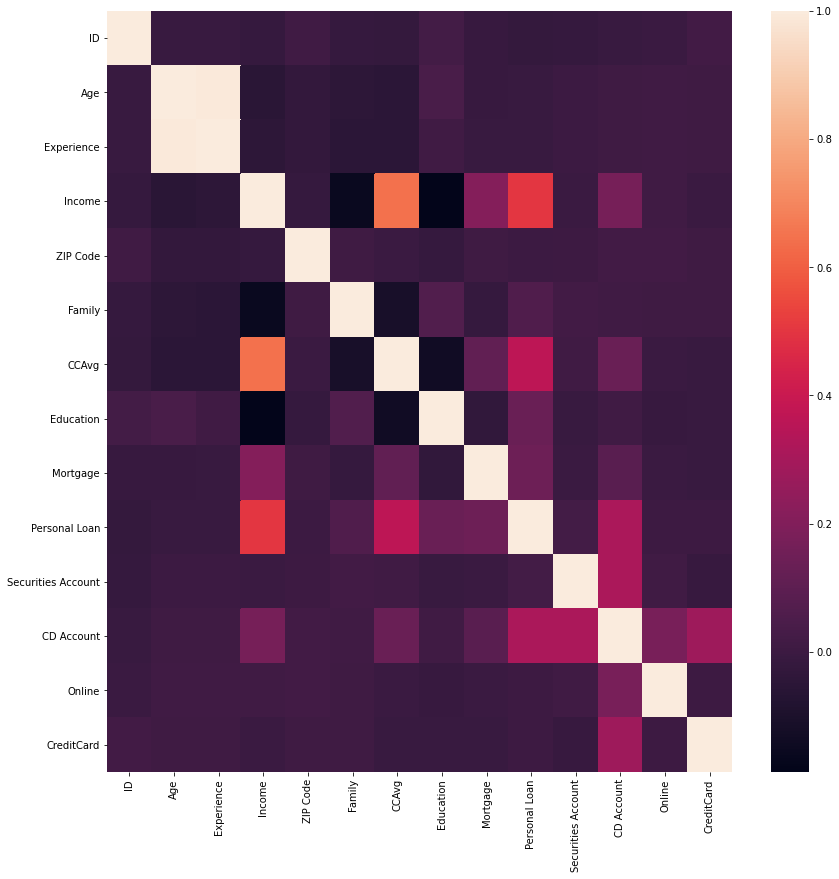

In [14]:
plt.figure(figsize=(14,14))
sns.heatmap(bank_data.corr())

### Get data model ready

In [15]:
bank_data = pd.get_dummies(bank_data, columns=['Education'], drop_first=True)
X = bank_data.drop(['ID','ZIP Code','Personal Loan'], axis=1)
y = bank_data['Personal Loan']

### I am dropping the ZIP CODE due its high cardinaliity but i can be reduced to some groups based on the leading digits 

# STEP 3

## Split the data into training and test set in the ratio of 70:30 respectively

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

# STEP 4

In [17]:
model = LogisticRegression()

In [18]:
model.fit(X_train, y_train)

LogisticRegression()

In [19]:
model.score(X_train, y_train)

0.9565714285714285

In [20]:
model.score(X_test, y_test)

0.9546666666666667

In [21]:
y_pred = model.predict(X_test)

In [22]:
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

Trainig accuracy 0.9565714285714285

Testing accuracy 0.9546666666666667

Confusion Matrix


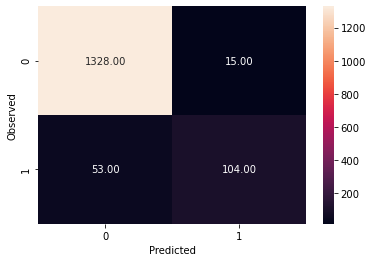

None

Recall: 0.6624203821656051

Precision: 0.8739495798319328

F1 Score: 0.7536231884057971

Roc Auc Score: 0.8256256787968754


In [23]:
print("Trainig accuracy",model.score(X_train,y_train))  
print()
print("Testing accuracy",model.score(X_test, y_test))
print()
print('Confusion Matrix')
print(draw_cm(y_test, y_pred))
print()
print("Recall:",recall_score(y_test, y_pred))
print()
print("Precision:",precision_score(y_test, y_pred))
print()
print("F1 Score:",f1_score(y_test, y_pred))
print()
print("Roc Auc Score:",roc_auc_score(y_test, y_pred))

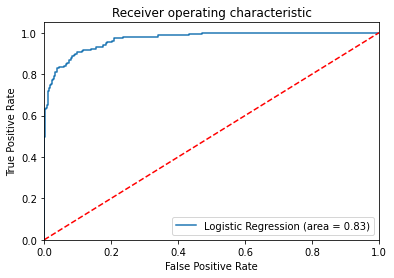

In [24]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## STEP5

In [25]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
# Running a loop to check different values of 'solver'
# all solver can be used with l2, only 'liblinear' and 'saga' works with both 'l1' and 'l2'

train_score=[]
test_score=[]
solver = ['newton-cg','lbfgs','liblinear','sag','saga']
for i in solver:
    model = LogisticRegression(random_state=42,penalty='l2', C = 0.75,solver=i)  # changing values of solver
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_test)     
    train_score.append(round(model.score(X_train, y_train),3))
    test_score.append(round(model.score(X_test, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

[0.956, 0.957, 0.956, 0.911, 0.909]

[0.96, 0.957, 0.956, 0.905, 0.901]


### I can see using newton cg and dropping c to 0.75 increased the accuracy from 0.954 to 0.96

In [27]:
train_score=[]
test_score=[]
solver = ['liblinear','saga']   # changing values of solver which works with 'l1'
for i in solver:
    model = LogisticRegression(random_state=42,penalty='l1', C = 0.75,solver=i)  #changed penalty to 'l1'
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_test)     
    train_score.append(round(model.score(X_train, y_train),3))
    test_score.append(round(model.score(X_test, y_test),3))
    
print(solver)
print()
print(train_score)
print()
print(test_score)

['liblinear', 'saga']

[0.957, 0.909]

[0.961, 0.901]


## Changing penalty from l2 regularizer to l1 increased the accuracy sligtly to 0.961

In [28]:
model = LogisticRegression(random_state=42,penalty='l1',solver='liblinear',class_weight='balanced') # changing class weight to balanced

model.fit(X_train, y_train) 

y_predict = model.predict(X_test)     

print("Trainig accuracy",model.score(X_train,y_train))  
print()
print("Testing accuracy",model.score(X_test, y_test))

Trainig accuracy 0.898

Testing accuracy 0.8953333333333333


## Using balanced class weight decreased the accuracy

In [29]:
# Running a loop to check different values of 'C'

train_score=[]                                 
test_score=[]
C = [0.01,0.1,0.25,0.5,0.75,1]
for i in C:
    model = LogisticRegression(random_state=42,penalty='l1', solver='liblinear',class_weight='balanced', C=i)  # changing values of C
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_test)     
    train_score.append(round(model.score(X_train,y_train),3))  
    test_score.append(round(model.score(X_test, y_test),3))    
    
print(C)
print()
print(train_score)
print()
print(test_score)

[0.01, 0.1, 0.25, 0.5, 0.75, 1]

[0.856, 0.893, 0.895, 0.899, 0.898, 0.898]

[0.853, 0.891, 0.895, 0.895, 0.895, 0.895]


In [30]:
train_score=[]                                 
test_score=[]
C = [0.01,0.1,0.25,0.5,0.75,1]
for i in C:
    model = LogisticRegression(random_state=42,penalty='l1', solver='liblinear', C=i)  
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_test)     
    train_score.append(round(model.score(X_train,y_train),3))  
    test_score.append(round(model.score(X_test, y_test),3))   
    
print(C)
print()
print(train_score)
print()
print(test_score)

[0.01, 0.1, 0.25, 0.5, 0.75, 1]

[0.911, 0.951, 0.956, 0.957, 0.957, 0.958]

[0.907, 0.946, 0.957, 0.958, 0.961, 0.96]


## STEP 5

### The model has as recall of 67  which means out of total people who actually took the loan the model predicted only 67% accurate which I will consider a bad result because I am loosing on 40 % of petential customers

### The model has as precision of 88  which means out of total people I predicted to take loan around 88% took the loan which is a very good score as the bank can save money here by targetting only the right people

### The model has an accuracy of 96 percent which looks good but this is not a vrey good metric since if my model predict all as not taking loan my accuracy will still be above 90%

###  Overall I would not suggest this model due to its low recall because the bank is loosing on a lot of potential customers, even though its saving some money on money on targetting the right customers but the I think the cost of loosing potential customers is more than spending on promotion.